In [22]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG19
import cv2
from torchvision import transforms
from PIL import Image

import zipfile
import os

In [2]:
zip_file = '/kaggle/input/platesv2/plates.zip'
destination_directory = '/kaggle/working/'
with zipfile.ZipFile(zip_file, 'r') as zip_obj:
    zip_obj.extractall(destination_directory)

In [3]:
def draw_samples(image_files):
    fig, axes = plt.subplots(4, 5, figsize=(15, 15))
    axes = axes.flatten()
    for i, image_file in enumerate(image_files[:4 * 5]):
        img = mpimg.imread(image_file)
        ax = axes[i]
        ax.imshow(img)
        ax.set_title("Cleaned" if i < 10 else "Dirty")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Image Processing

In [6]:
cleaned_path = '/kaggle/working/plates/train/cleaned/'
dirty_path = '/kaggle/working/plates/train/dirty/'
test_path = '/kaggle/working/plates/test/'

image_files_cleaned = [os.path.join(cleaned_path, f) for f in os.listdir(cleaned_path) if f.endswith(('jpg', 'png', 'jpeg'))]
image_files_dirty = [os.path.join(dirty_path, f) for f in os.listdir(dirty_path) if f.endswith(('jpg', 'png', 'jpeg'))]
image_test_files = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith(('jpg', 'png', 'jpeg'))]

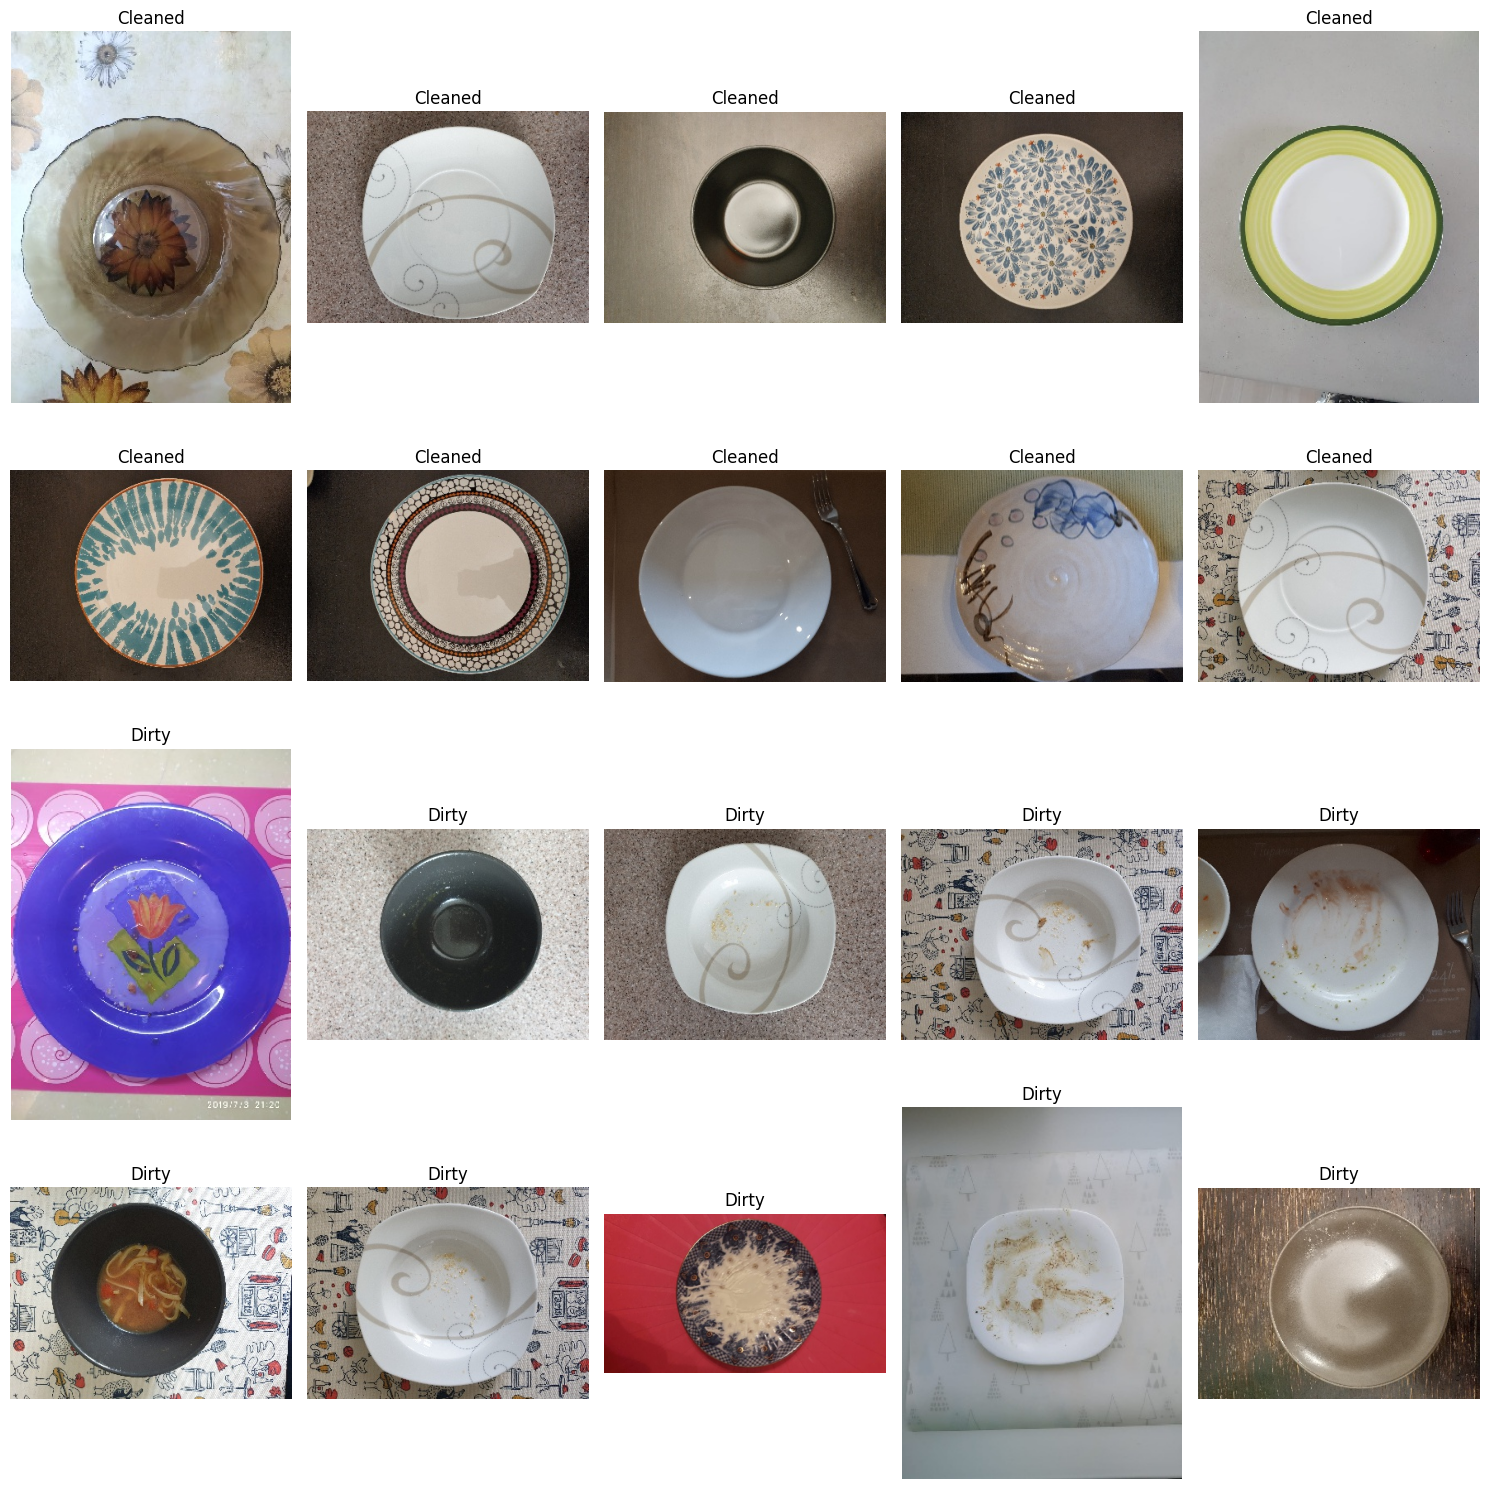

In [7]:
draw_samples(image_files_cleaned[:10] + image_files_dirty[:10])

In [8]:
def get_image_dimensions(folder_path):
    min_width = min_height = float('inf')
    max_width = max_height = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)
        except:
            continue
    return min_width, min_height, max_width, max_height
    
cleaned_dimensions = get_image_dimensions(cleaned_path)
dirty_dimensions = get_image_dimensions(dirty_path)
test_dimensions = get_image_dimensions(test_path)

print("Cleaned folder - Min Width: {}, Min Height: {}, Max Width: {}, Max Height: {}".format(*cleaned_dimensions))
print("Dirty folder - Min Width: {}, Min Height: {}, Max Width: {}, Max Height: {}".format(*dirty_dimensions))
print("Test folder - Min Width: {}, Min Height: {}, Max Width: {}, Max Height: {}".format(*test_dimensions))

Cleaned folder - Min Width: 256, Min Height: 256, Max Width: 454, Max Height: 455
Dirty folder - Min Width: 256, Min Height: 256, Max Width: 454, Max Height: 454
Test folder - Min Width: 256, Min Height: 256, Max Width: 454, Max Height: 454


In [9]:
def remove_background(image_files, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for i, file in enumerate(image_files):
        img_original = cv2.imread(file)
        height, width = img_original.shape[:2]
    
        # Using OpenCV grabCut
        mask = np.zeros([height, width], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (15, 15, width - 30, height - 30)
        
        cv2.grabCut(img_original, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
    
        mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
        out_img = img_original * mask[:, :, np.newaxis]
        background = img_original - out_img
        background[np.where((background > [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        out_img = background + out_img
        
        img_cleaned = transforms.functional.to_pil_image(out_img)
        img_cleaned = np.array(img_cleaned)

        file_name = file.rsplit('/', 1)[-1]
        cv2.imwrite(os.path.join(output_path, file_name), img_cleaned)

In [10]:
processed_cleaned_path = '/kaggle/working/plates/train_processed/cleaned/'
processed_dirty_path = '/kaggle/working/plates/train_processed/dirty/'
processed_test_path = '/kaggle/working/plates/test_processed/'

remove_background(image_files_cleaned, processed_cleaned_path)
remove_background(image_files_dirty, processed_dirty_path)
remove_background(image_test_files, processed_test_path)

image_files_processed_cleaned = [os.path.join(processed_cleaned_path, f) for f in os.listdir(processed_cleaned_path) if f.endswith(('jpg', 'png', 'jpeg'))]
image_files_processed_dirty = [os.path.join(processed_dirty_path, f) for f in os.listdir(processed_dirty_path) if f.endswith(('jpg', 'png', 'jpeg'))]
image_files_processed_test = [os.path.join(processed_test_path, f) for f in os.listdir(processed_test_path) if f.endswith(('jpg', 'png', 'jpeg'))]

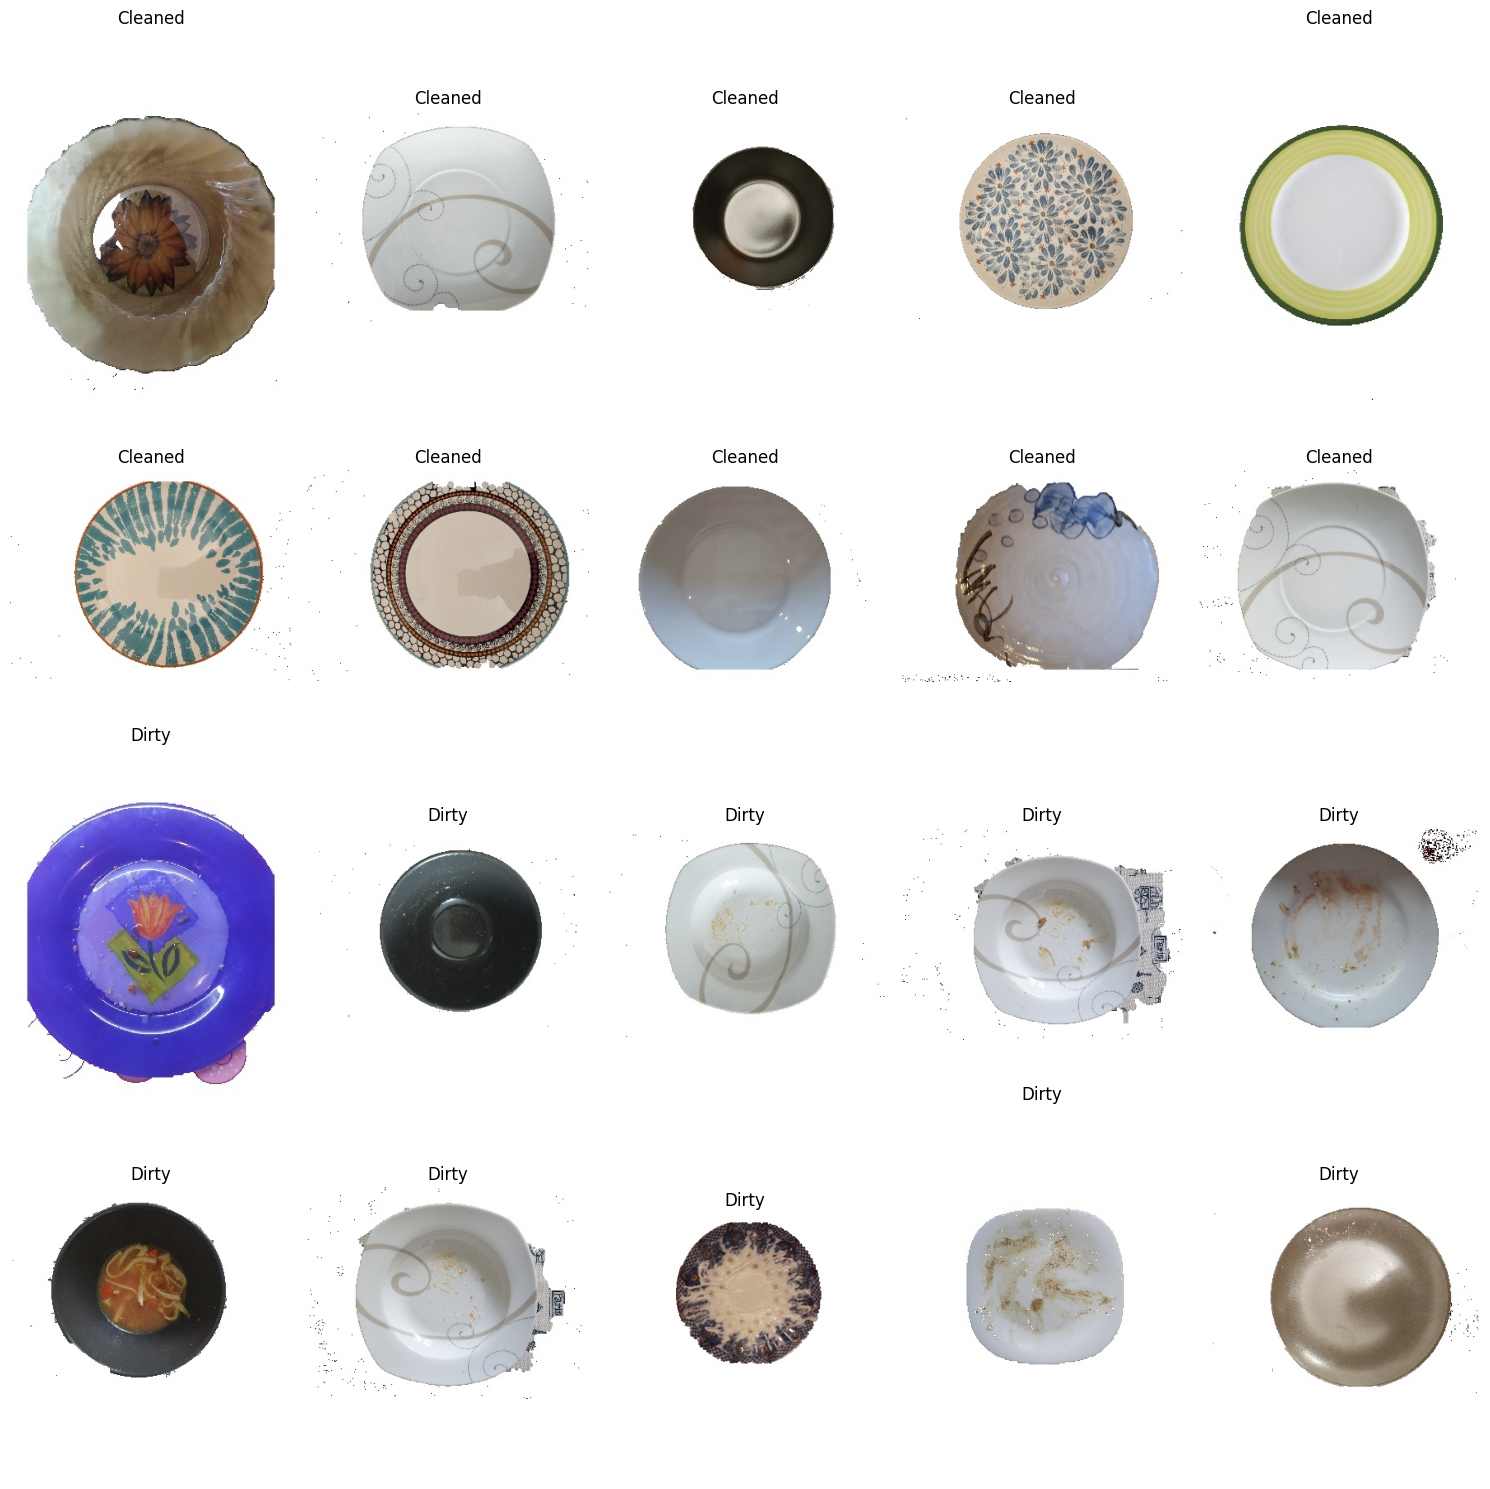

In [11]:
draw_samples(image_files_processed_cleaned[:10] + image_files_processed_dirty[:10])

In [12]:
X_train = []
y_train = []

def load_images(image_files, label):
    for filename in image_files:
        img = cv2.imread(filename)
        img = cv2.resize(img, (224, 224))
        X_train.append(img)
        y_train.append(label)
        
load_images(image_files_processed_cleaned, 0)
load_images(image_files_processed_dirty, 1)
# load_images(image_files_cleaned, 0)
# load_images(image_files_dirty, 1)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(y_train)

X_train shape: (40, 224, 224, 3)
y_train shape: (40,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [13]:
X_test = []
for filename in image_files_processed_test:
# for filename in image_test_files:
    img = cv2.imread(filename)
    img = cv2.resize(img, (224, 224))
    X_test.append(img)
X_test = np.array(X_test)
print(f"X_test shape: {X_test.shape}")

X_test shape: (744, 224, 224, 3)


## Train

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 20

In [15]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
train_gen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [24]:
pretrained = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

pretrained.trainable = False

model = Sequential([
    pretrained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='swish'),
    layers.Dense(256, activation='tanh'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = model.fit(train_gen, epochs=EPOCHS)

# checkpoint_callback = ModelCheckpoint(
#     'best_model.keras',
#     monitor='accuracy',
#     mode='max',
#     save_best_only=True
# )

# history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint_callback])

In [ ]:
# best_model = load_model('best_model.keras')
predictions = model.predict(X_test)

In [ ]:
submission = pd.DataFrame({'id': [n for n in range(len(predictions))], 'label': ['dirty' if x > 0.5 else 'cleaned' for x in predictions]})
print(submission['label'].value_counts())
submission.to_csv('/kaggle/working/submission.csv', index=False)